# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# Scentinel Elasticnet Transductive workflow

##### Ver:: A0_V2_1
##### Author(s) : Issac Goh
##### Date : 231210;YYMMDD
### Author notes
    - Feel free to feed this model latent representations which capture non-linear relationships, the model will attempt to resolve any linearly seperable features. Feature engineering can be applied here.
    
### Features to add
    - Add ability to consume anndata zar format for sequential learning
    
### Modes to run in
    - Run in training mode
    - Run in projection mode

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl
import matplotlib.pyplot as plt


#¢ new modules
import psutil
import time
import threading
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty
import scipy

In [3]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
'int_atlas_sub':'/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/example_notebooks/Simple_sampled_adata_V1.h5ad',
'int_atlas_full':'/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad',
}

#setup global params:
# Variable assignment
train_model = True
adata_key = 'int_atlas_sub'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'new_example_model'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'LVL3'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False # should data be normalised?

# setup model parameters:
model_params = {
'feat_use': 'LVL2',
'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
    
# Stratified Bayes sampler kwargs
'sample_data_knn':True,
'straify_sampling':True, # Whether to stratify the sampling by "feat_use" or not
'knn_key' : 'neighbors',
'sampling_rate': 0.1,# Apply empirical bayes sampling weighted by knn?
'weight_penalty': 'laplacian_SGD_pagerank', # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
'iterations': 10,#How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
'representation_priority': 0.7, # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
'replace': True, # Allows model to clone cells
'equal_allocation': False, # Forces model to create equal representation sets
'resample_clones':True, # Reduce the number of clone cells where possible
'pl_label_entropy':False,
    
    
# Params for SGD-pagerank
'num_iterations': 1000,# How many mini-batches to learn
'mini_batch_size': 10000,# How large should each mini-batch be
'full_batch_update_iters': 200, # How many full batch updates
'dynamic_hop' : True, # Perform dynamic hop operation?
'epoch' : 5, # This parameter controls the maxiumum number iterations prior to reconstruction
'alpha':0,  # This parameter controls the minimum number of hops to reach an anchor state -- this controls dynamic graph coverage
}

# Transductive workflow
- First we train a model on a subset of our data which we will then later use to generalise across our dataset.

- We sample our data using a set of empirical priors based on the known distribution of celltype labels, we then consider a weight to represent the liklihood of sampling by taking the sum of weights for each vertice sharing labels divided by vertices that have different labels. 

# Bayesian_balanced_stratified_sampling
This function, bayesian_balanced_stratified_sampling, performs stratified sampling on single-cell data stored in an AnnData object. It uses empirical Bayesian updating to balance the representation of each cell type (label) in the data. The sampling process considers the neighborhood relationships between cells, which helps maintain the local structure of the original data.

The sampling can be adjusted with several options, including:

equal_allocation: If enabled, each label gets an equal share of the total sample size. Otherwise, the sample size for each label is proportional to its prior probability.
replace: If enabled, sampling is done with replacement, allowing the model to create clones of cells.
iterations: Determines the number of times the sampling process is repeated, updating the label probabilities in each iteration.
The output is a new AnnData object containing the sampled cells and the indices of the sampled cells.

If left as default, underepresented states will naturally be prioritised in sampling as iterations increases, thus if you are experiencing issues with under representation, increase iterations. 

- Representation priority represents a wighting factor used to recover rare-states. 
- Prioritisation factor, this will heavily bias the sampling of under-represented states

Attention-based non-straified sampling selected
Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
No pre-rank vector provided, proceeding with randomised intialisation
Converged at iteration 163
Proceeding on to perform fine-tuning across full-batch


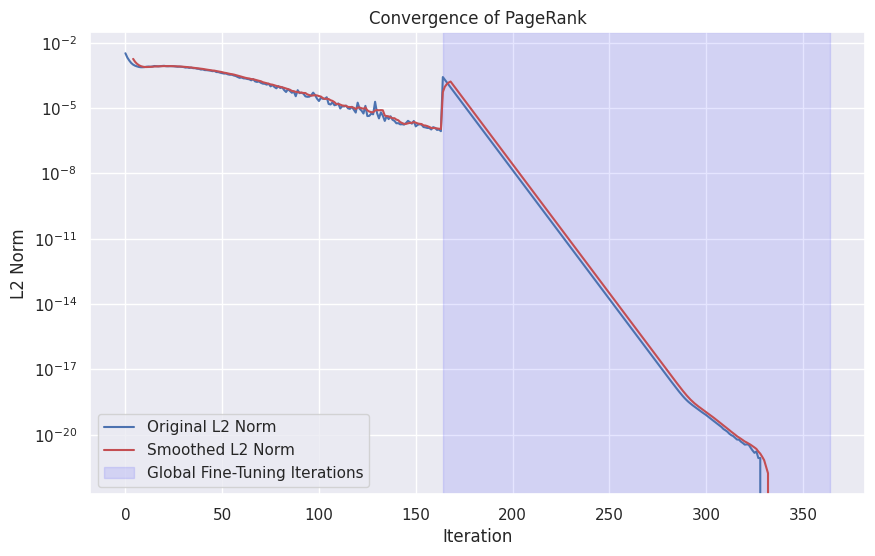

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!
adata_loaded


In [3]:
adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed='r')

if model_params['sample_data_knn'] != False:
    if model_params['straify_sampling'] == True:
        print('Empirical bayes sampling option selected')
        adata_samp, indices, weights = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, **model_params)
        scent.plot_sampling_metrics(adata,adata_samp, **model_params)
        adata_samp = adata_samp.to_memory()
    else:
        print('Attention-based non-straified sampling selected')
        adata_samp,sample_probs, weights = scent.Attention_based_KNN_sampling(adata, **model_params)
        adata_samp = adata_samp.to_memory()
print('adata_loaded')

### Removed "feat_use" from model params to demonstrate that non-stratified sampler is independent of labels
- added back in below to show conservation of cell-states

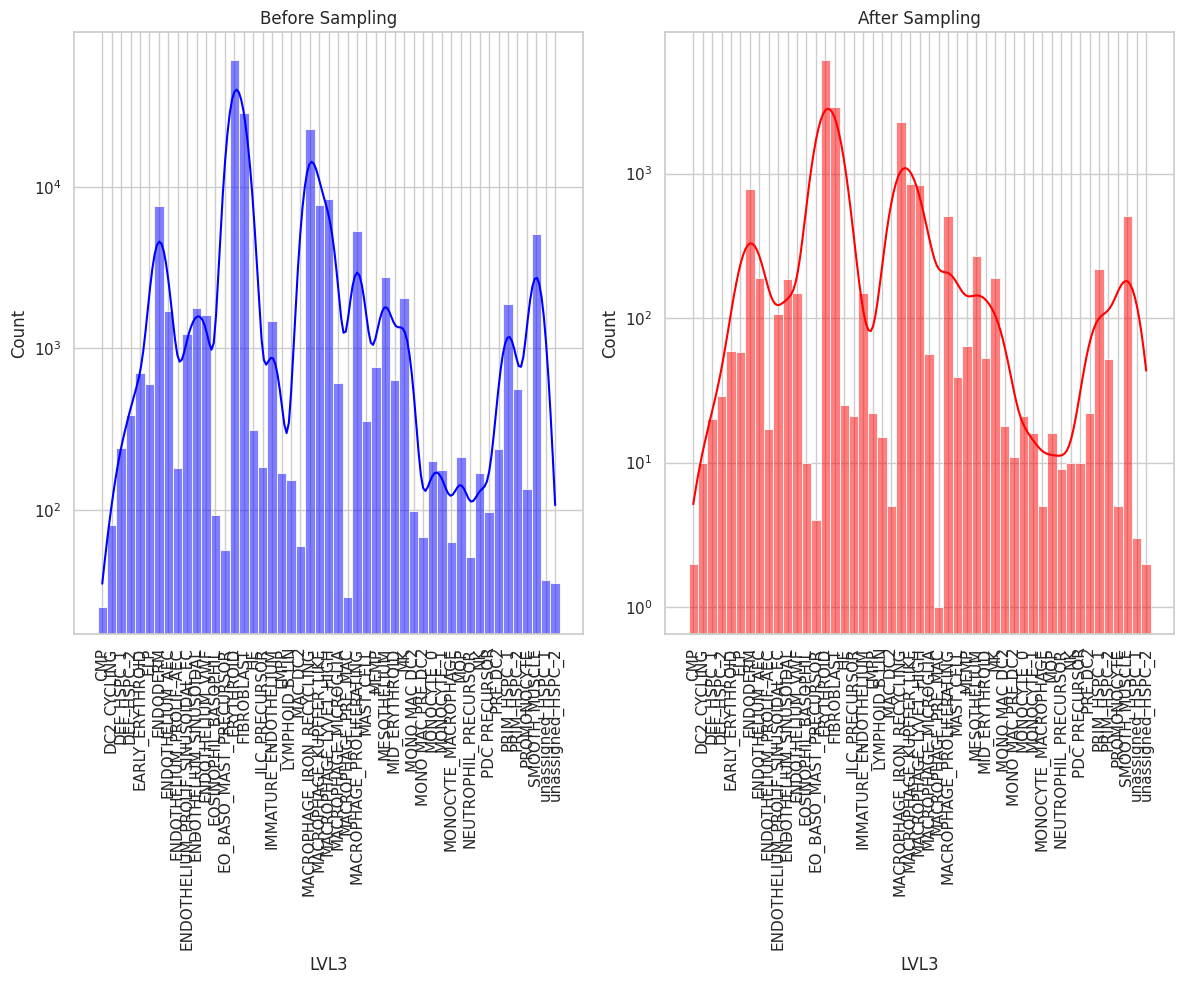

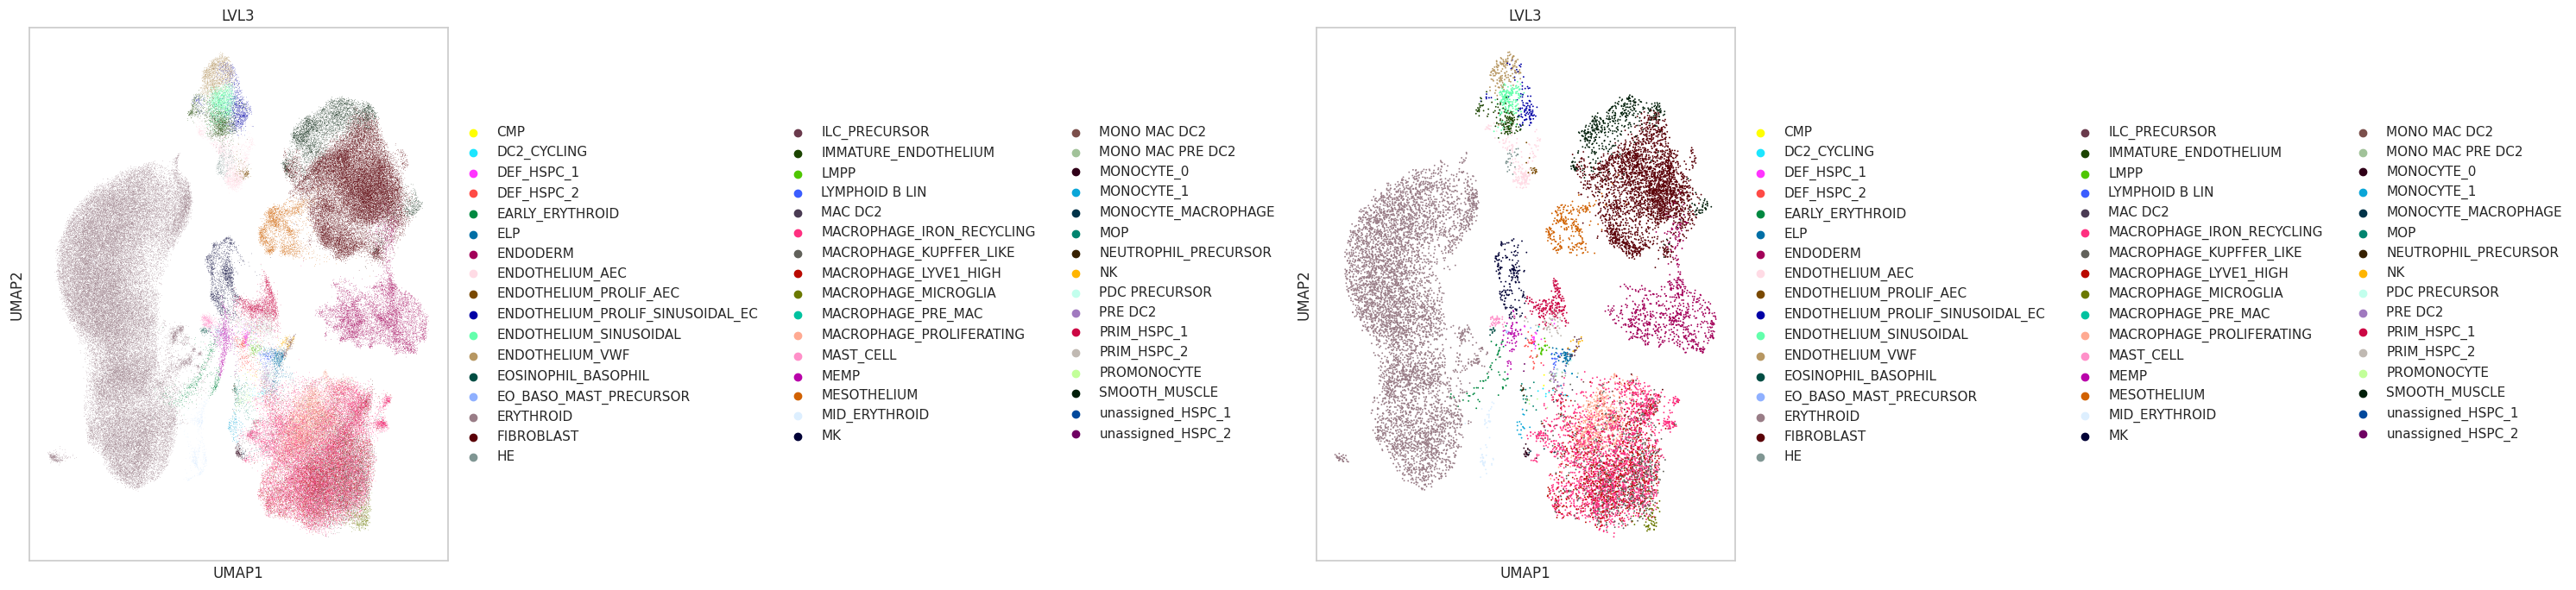

In [52]:
model_params['feat_use']= 'LVL3'
scent.plot_sampling_metrics(adata,adata_samp, **model_params)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(30,7))

# Plot the UMAPs on these axes
sc.pl.umap(adata, color=model_params['feat_use'], ax=axs[0], show=False)
sc.pl.umap(adata_samp, color=model_params['feat_use'], ax=axs[1], show=False)
# Display the plots
plt.tight_layout()
plt.show()

# Show the sampling distribution

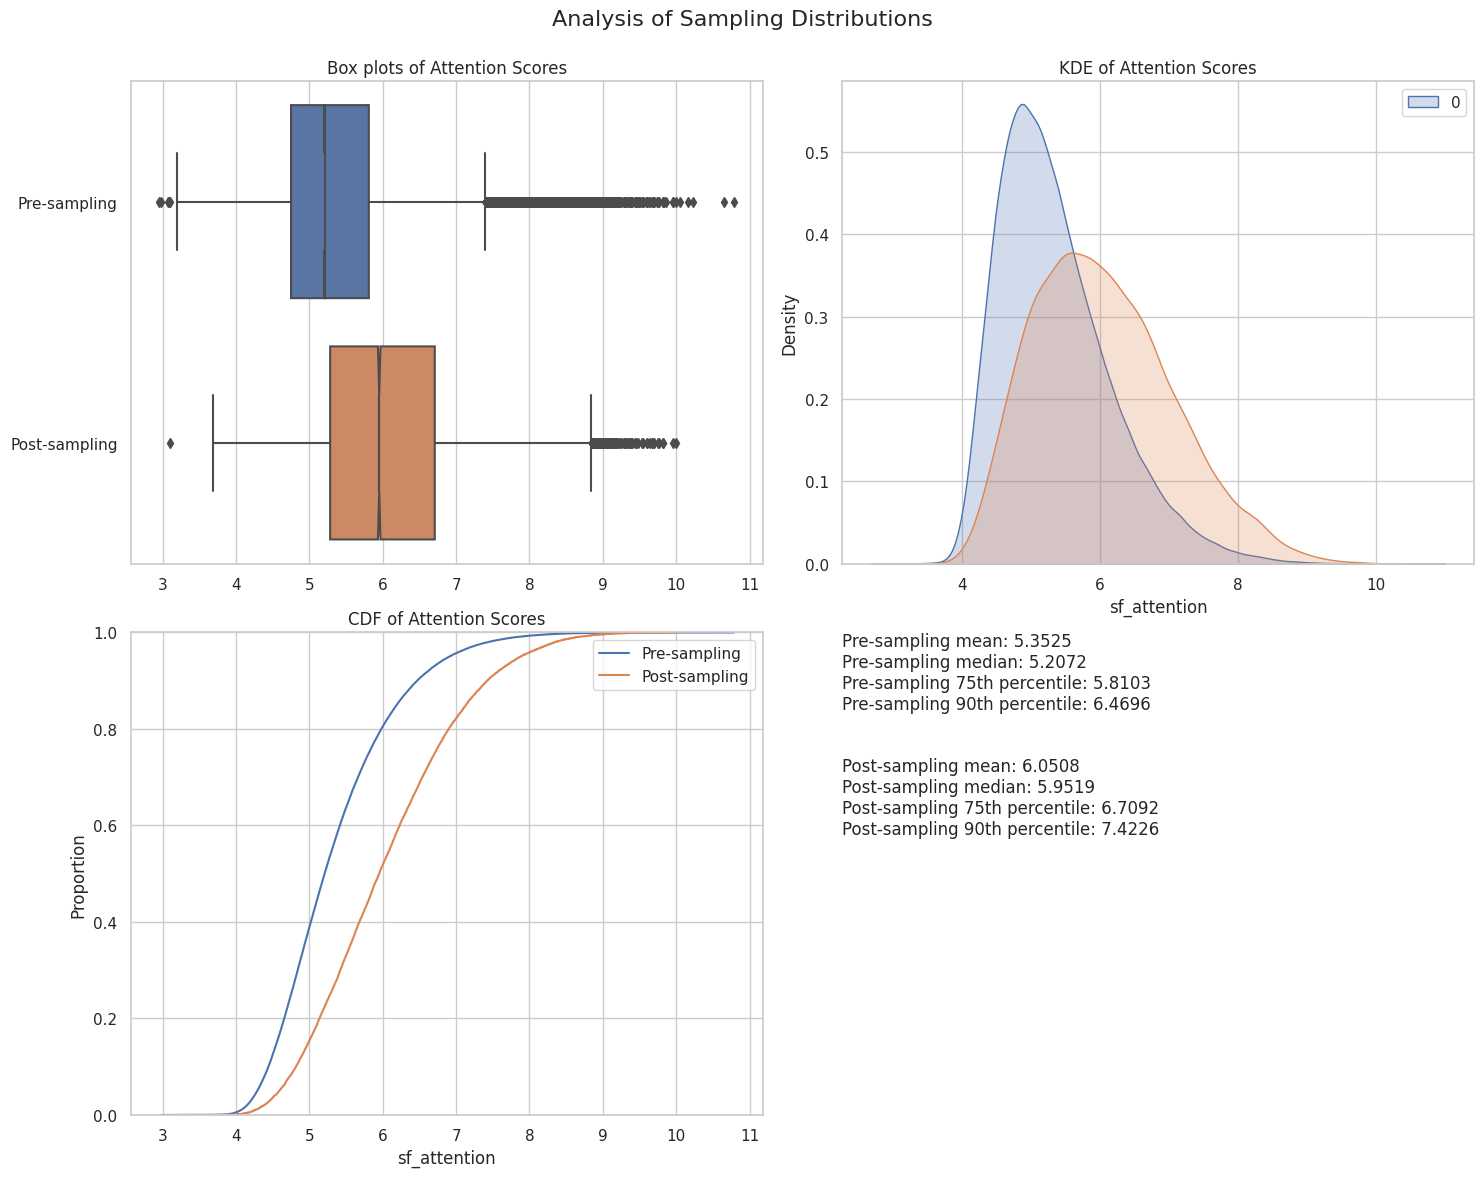

In [53]:
# Extract attention scores
pre_sample_scores = weights['all_weights']
post_sample_scores = adata_samp.obs['sf_attention']
scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)

# Optionally expand neighborhoods to explicitly cover all nodes in graph
### Notes:
- This application still doesn't apply the adaptive gaussian kernel
- This module can be computationally expensive during reconstruction of the graph

### potential updates
- Add a loss function for vertice distribution or simple eigen vector cosine distance
- Future updates will only reconstruct the connectivity matrix from the anchor-states


#### Simple measure if all cells are connected to minimum 1 pseudocell

- Set anchor states as selected pseudocells
- All cells must be connected to a minimum of alpha pseudostates
- Neighborhood hop performed dynamically


### Workflow:
- Compute naive sampling with attention scores
- Iteratively expand neighborhod until they meet a minimum alpha
- Recompute updated pagerank chunk
- Re-sample and test for connectivity.


Epoch: 0
Updating connectivity matrix in chunks


Updating connectivity matrix: 100%|██████████| 10/10 [01:24<00:00,  8.48s/it]


Remaining unconnected node count is: 0
Attention-based non-straified sampling selected
Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
Pre-initialised vector provided
Converged at iteration 741
Proceeding on to perform fine-tuning across full-batch


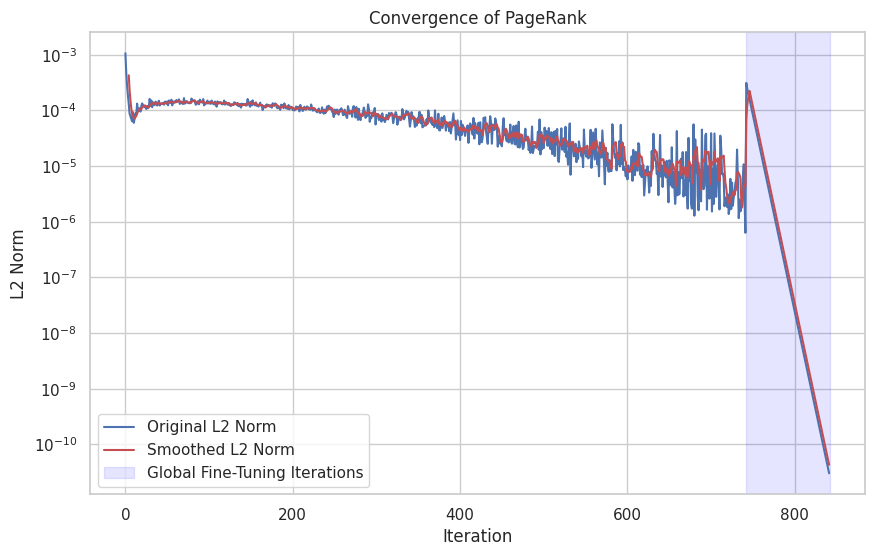

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!


In [55]:
if model_params['dynamic_hop'] == True:
    results = scent.expand_neighborhoods_chunked(adata, adata_samp, model_params) #param_set
    update_mat = results['main_matrix']
    model_params['init_vect'] = weights['v']
    # Set the updated neighborhood expansion as main KNN matrix
    adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']] = update_mat
    
    # Re-run SGD_pgr with updated mat and pre-established v vector
    if model_params['sample_data_knn'] != False:
        if model_params['straify_sampling'] == True:
            print('Empirical bayes sampling option selected')
            adata_samp, indices, weights = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, **model_params)
            scent.plot_sampling_metrics(adata,adata_samp, **model_params)
            adata_samp = adata_samp.to_memory()
        else:
            print('Attention-based non-straified sampling selected')
            adata_samp,sample_probs, weights = scent.Attention_based_KNN_sampling(adata, **model_params)
            adata_samp = adata_samp.to_memory()

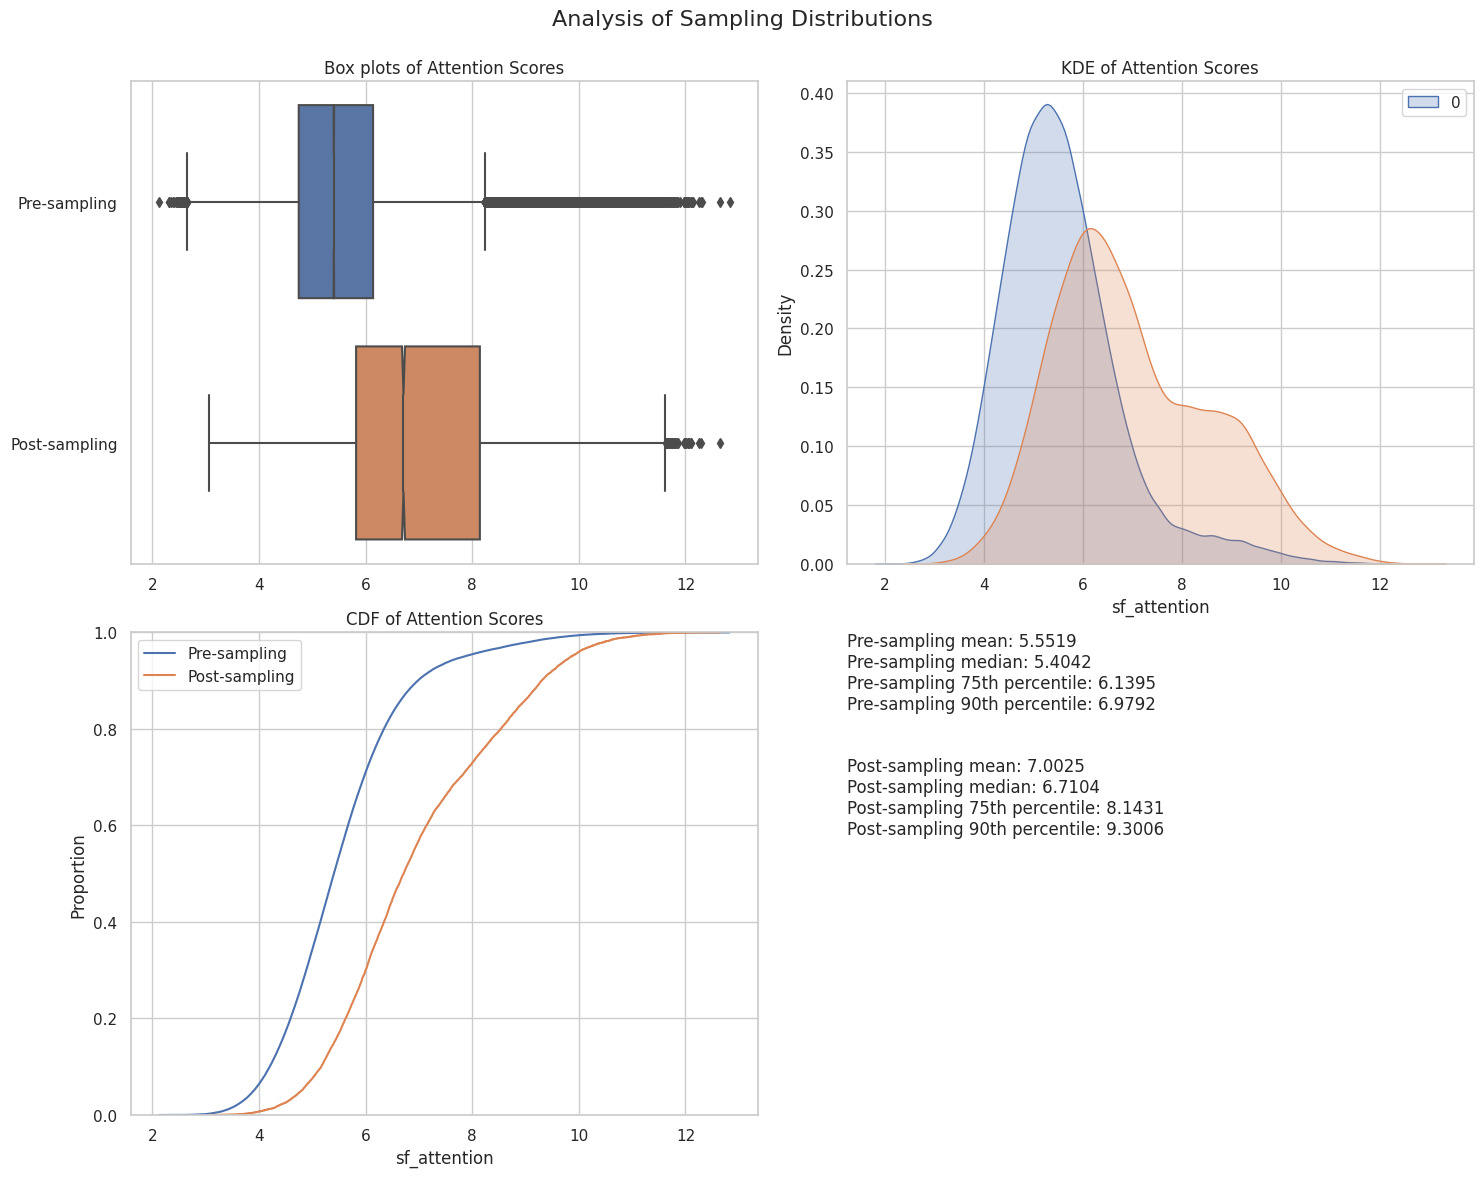

In [56]:
pre_sample_scores = weights['all_weights']
post_sample_scores = adata_samp.obs['sf_attention']
scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)

# Compare sampling bias against Randomised boostrap sampling distribution

Missing categories in samp_obs: PDC PRECURSOR


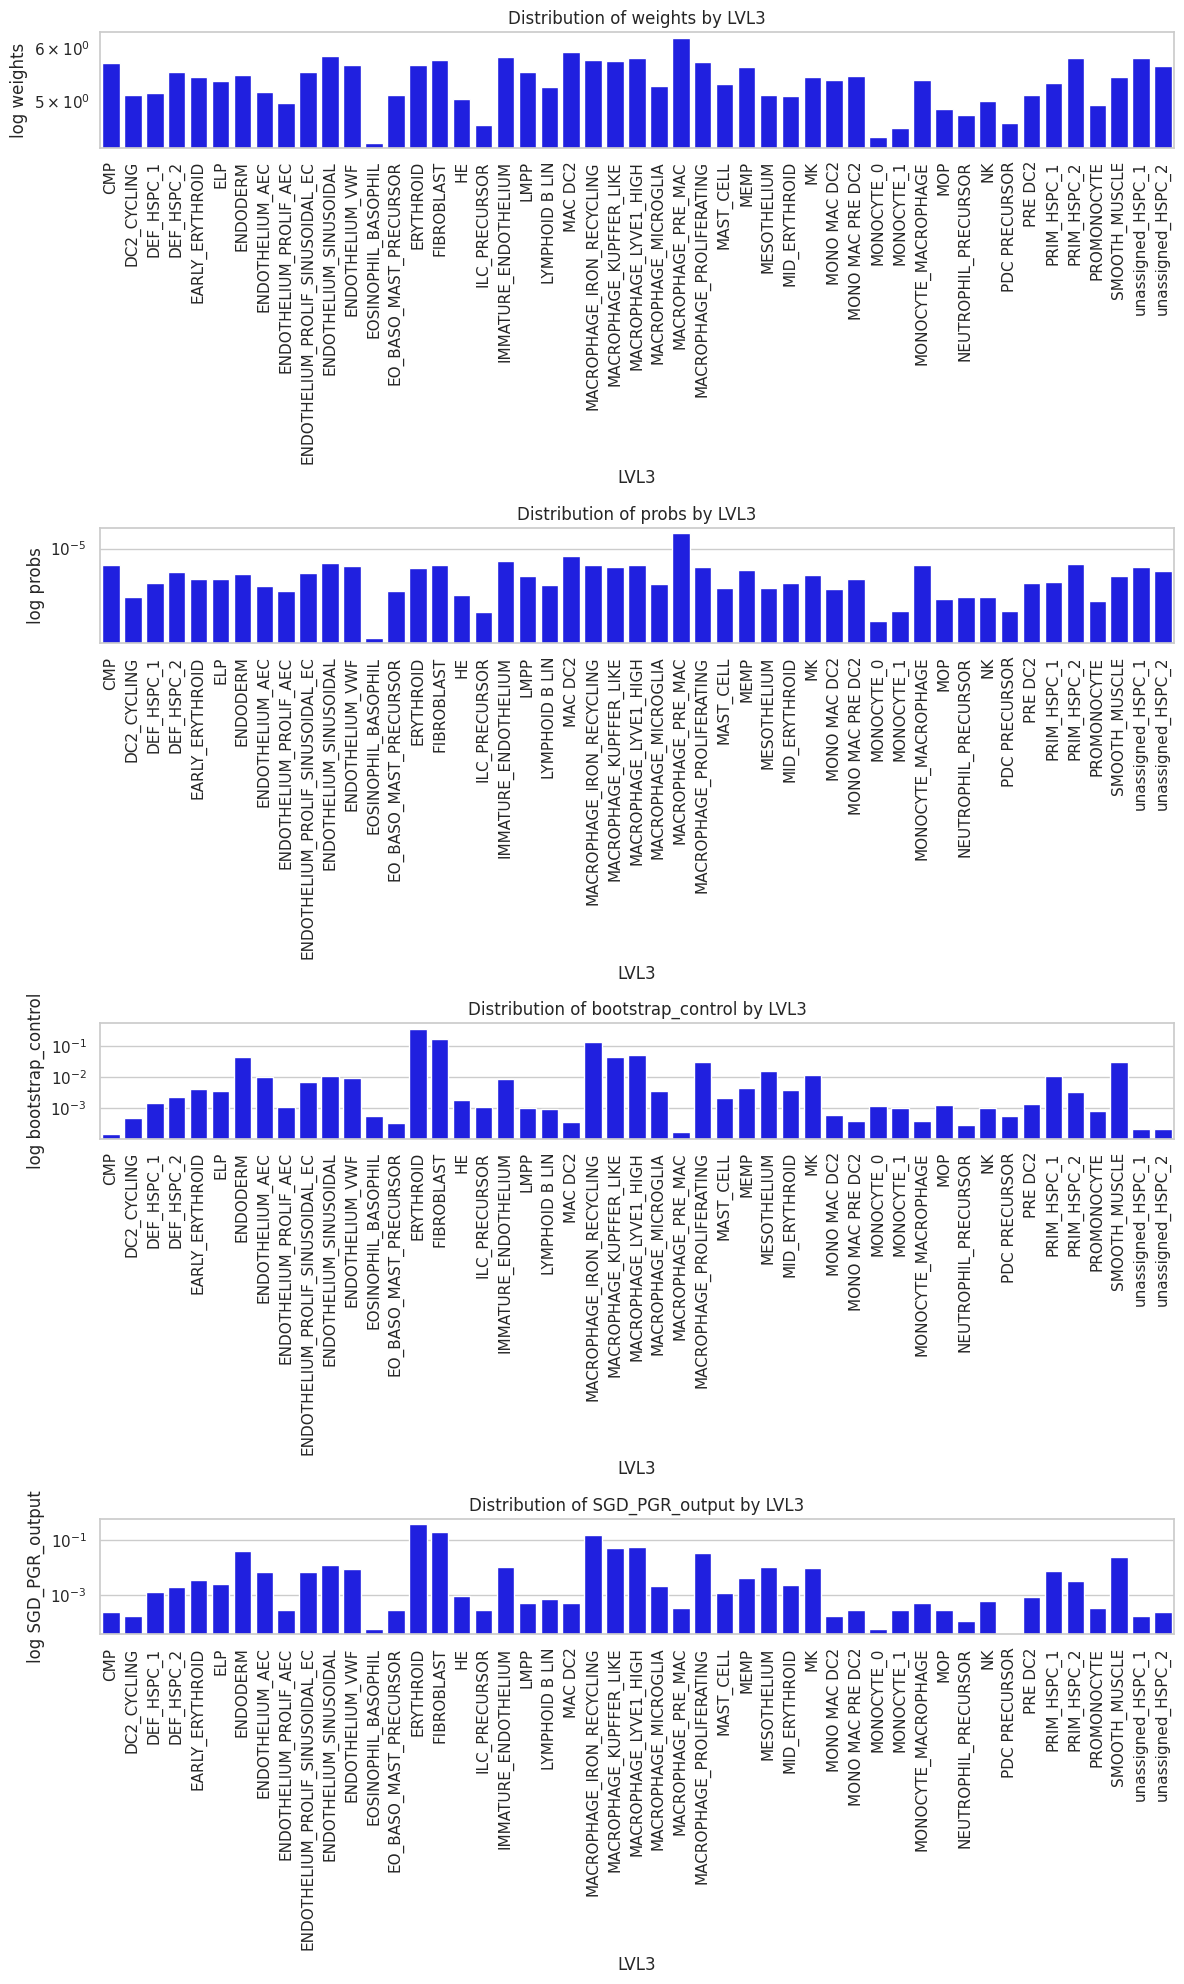

In [57]:
grouping = model_params['feat_use']
plot_vars = ['weights', 'probs', 'bootstrap_control', 'SGD_PGR_output']

obs = adata.obs.copy()
# Create a randomized sampling 
random_sampling_probabilities = scent.compute_sampling_probability(obs, grouping)
# Add the SGD_PGR sampled data distribution
samp_obs = adata_samp.obs.copy()
samp_obs = dict(samp_obs.groupby(grouping).size()/sum(samp_obs.groupby(grouping).size()))

obs['weights'] = weights['all_weights']
obs = obs.iloc[list(sample_probs.keys())]
obs['probs'] = list(sample_probs.values())
obs = obs.groupby(grouping).mean()
# Add random sampling
obs['bootstrap_control'] = [random_sampling_probabilities[group] for group in obs.index]

# Handle missing categories and add SGD_PGR sampled data
missing_categories = []
sgd_pgr_output = []

for group in obs.index:
    try:
        sgd_pgr_output.append(samp_obs[group])
    except KeyError:
        missing_categories.append(group)
        sgd_pgr_output.append(None)  # Or any default value you'd prefer, like np.nan

obs['SGD_PGR_output'] = sgd_pgr_output

if missing_categories:
    print(f"Missing categories in samp_obs: {', '.join(missing_categories)}")

scent.plot_grouped_distributions(obs, plot_vars, grouping)

# Neighborhood-Based Pseudobulk Aggregation of anchor node neighborhoods in scRNA-seq Data#

### Methodology for Neighborhood-Based Pseudobulk Aggregation of scRNA-seq Data

#### Update ver A0.1.2 -- 
   - Updated aggregation function to detect backed readings
   - if data is backed, assume large X partition is inevitable & create chunked reads of X for updates

#### Background:
Single-cell RNA sequencing (scRNA-seq) datasets capture diverse biological states across many cells, making it computationally challenging to analyze them directly. Pseudobulk aggregation offers a way to distill this complexity by combining data from multiple cells. This method aggregates cells based on local neighborhoods, ensuring a more biologically meaningful representation. Additionally, it incorporates a normalization step inspired by the scVI model, providing a balanced representation of each cell within its local context.

#### Objective:
To generate pseudobulk gene expression profiles by aggregating cells within neighborhoods defined by a k-nearest neighbors (KNN) connectivity matrix, ensuring that each cell's contribution is fairly represented based on its local context.

#### Method:
Given a scRNA-seq dataset with $( N $) cells and $( G $) genes represented by a matrix $( X $) of dimensions $( N $times G $), and a KNN connectivity matrix $( C $) of dimensions $( N $times N $), we aim to aggregate data in neighborhoods of sampled cells to produce pseudobulk profiles.

1. **Neighborhood Definition**:
For a given sampled cell $( i $), its neighborhood is defined by the non-zero entries in row $( i $) of the KNN connectivity matrix $( C $).

$$ \text{Neighborhood}(i) = \{ j | C_{ij} > 0 \} $$

2. **Local Scaling Factors**:
For each neighborhood associated with a sampled cell \( i \), a scaling factor is computed for every cell in that neighborhood based on the cell's total counts relative to the average counts of cells within that neighborhood.

$$ \text{LocalScalingFactor}(j) = \frac{\sum_{g=1}^{G} X_{jg}}{\frac{1}{|\text{Neighborhood}(i)|} \sum_{n \in \text{Neighborhood}(i)} \sum_{g=1}^{G} X_{ng}} $$

where \( j \) is a cell in the neighborhood of sampled cell \( i \).

3. **Neighborhood Aggregation**:
For each sampled cell \( i \), the pseudobulk profile is generated by aggregating the expression data of its neighborhood cells. The aggregated expression of gene \( g \) for cell \( i \) is given by:

$$ \text{Pseudobulk}_{ig} = \frac{\sum_{j \in \text{Neighborhood}(i)} \text{LocalScalingFactor}(j) \times X_{jg}}{\sum_{j \in \text{Neighborhood}(i)} \text{LocalScalingFactor}(j)} $$

This results in a matrix \( P \) of dimensions \( S \times G \), where \( S \) is the number of sampled cells.


#### Why account for scaling factors by total counts?

1. **Accounting for Differences in Sequencing Depth**: 
   In scRNA-seq experiments, there can be variability in the number of UMIs (Unique Molecular Identifiers) or total reads captured for each cell. This variation can arise due to technical biases, efficiency of RNA capture, or other factors. The scaling factor normalization ensures that each cell's expression profile is scaled to a common reference, which reduces the impact of this variability on downstream analyses.

2. **Fair Representation**:
   By scaling each cell's expression data with its corresponding factor, you ensure that no single cell (or group of cells with higher sequencing depth) unduly dominates the aggregated pseudobulk profile. This is especially important in neighborhood-based aggregation where you want the pseudobulk profile to be a representative summary of all cells in the neighborhood.

3. **Enhancing Biological Signal**:
   Normalizing by a scaling factor can help in emphasizing the biological variability over the technical variability. This is particularly useful when looking for differentially expressed genes or when clustering cells, as it allows for biological differences between cells or groups of cells to become more apparent.

4. **Comparability**:
   Scaling ensures that the aggregated profiles (or even individual cell profiles) from different samples, experiments, or batches can be compared directly. Without normalization, differences in sequencing depth or technical biases might confound the biological interpretations.

5. **Stabilizing Variance**:
   In many high-dimensional datasets, including scRNA-seq, the variance often scales with the mean. By normalizing using a scaling factor, this relationship can be stabilized, which can be crucial for many downstream statistical analyses.

In summary, normalizing to a scaling factor prior to aggregation is essential to ensure that the aggregated data is free from technical biases, represents all cells fairly, and highlights true biological differences. It sets a consistent baseline across cells, making the aggregated profiles more interpretable and comparable.

In [14]:
# Create pseudocells from the main data
from tqdm import tqdm
import gc
adata_samp = adata[adata.obs.index.isin(adata_samp.obs.index)].to_memory()
connectivity_matrix = adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']]
pseudobulk_adata = scent.aggregate_data(adata, adata_samp, connectivity_matrix, method='local',chunk_size = 1000) # method = "sum" aggregate by sum for equal weighting for all neighbors

Data is too large to process in a single view, processing in chunks 


Processing chunks: 100%|██████████| 17/17 [00:51<00:00,  3.05s/chunk]


In [9]:
pseudobulk_adata

AnnData object with n_obs × n_vars = 16949 × 37318
    obs: 'file', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample', 'anno_lvl_2_final_clean', 'celltype_annotation', 'cell.labels', 'stage', 'lanes', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'dataset_merge', 'index_orig', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'new_data_handle', 'batch', 'HDBR_ID', 'leiden_scvi_res15', 'num', 'cell.labels_num', 'leiden_scvi_res15_num', 'clus_prediction', 'clus_prediction_num', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'restricted_leiden_scvi_res15', 'umap_density_clus_prediction', 'umap_density_clus_prediction_AEC', 'cell.labels_v2_num', 'scrublet_score', 'scrublet_cluster_score', 'scr_bh_pval', 'scr

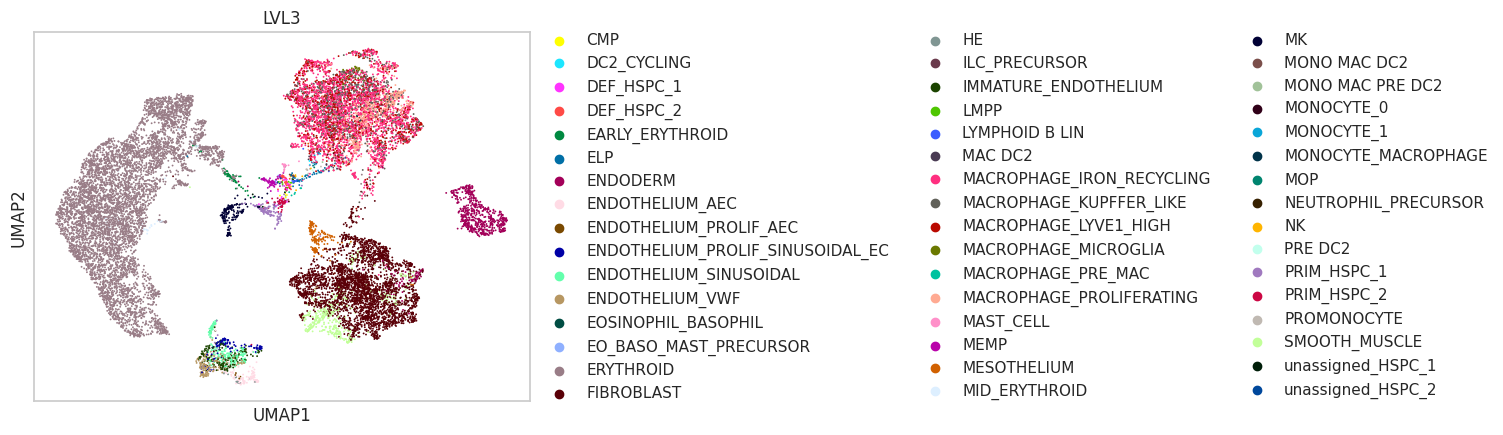

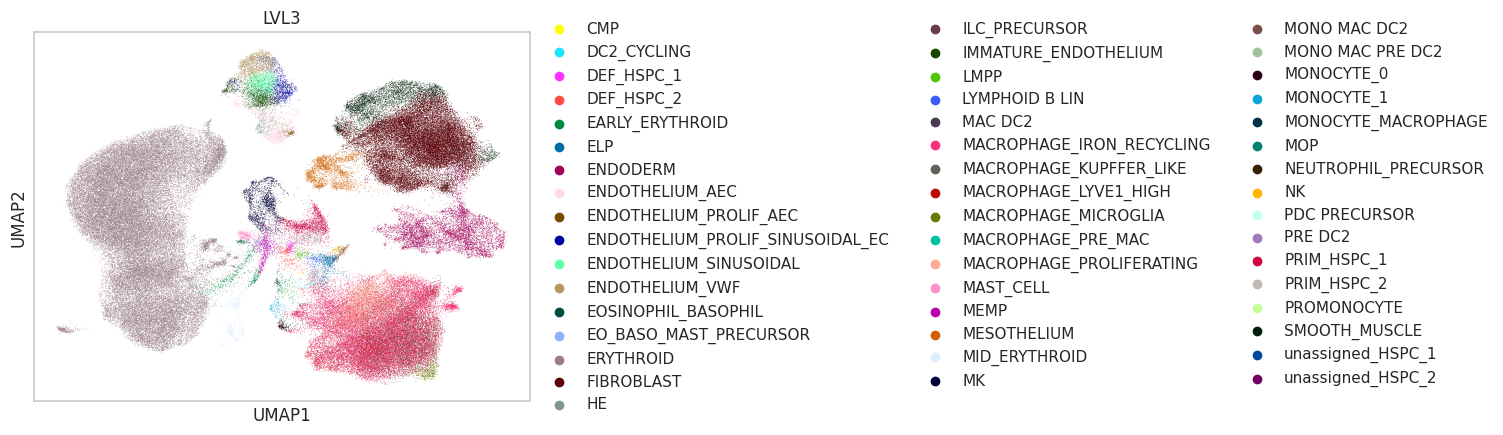

In [60]:
pseudobulk_adata_tt = pseudobulk_adata.copy()
sc.pp.normalize_per_cell(pseudobulk_adata_tt, counts_per_cell_after=1e4)
sc.pp.log1p(pseudobulk_adata_tt)
print(np.max(pseudobulk_adata_tt.X))
#pseudobulk_adata.obsm = adata_samp.obsm
sc.pp.highly_variable_genes(pseudobulk_adata_tt, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(pseudobulk_adata_tt,use_highly_variable=True)
sc.pp.neighbors(pseudobulk_adata_tt, n_neighbors=30, n_pcs=30)
sc.tl.umap(pseudobulk_adata_tt)
sc.pl.umap(pseudobulk_adata_tt,color = 'LVL3')
sc.pl.umap(adata,color = 'LVL3')

# This output shows that updating connectivity via dynamic hop expansion is useful for allowing pagerank to consider a larger graph context.
- We now get improved pagerank for sampled states, of which now include some of the previously missing cells
- We also now acquire an improved representation of importance
- We now only miss out 5 cells across the entire dataset

# If we don't conduct SGD-PGR and just randomly sample then create pseudocells

8.848947


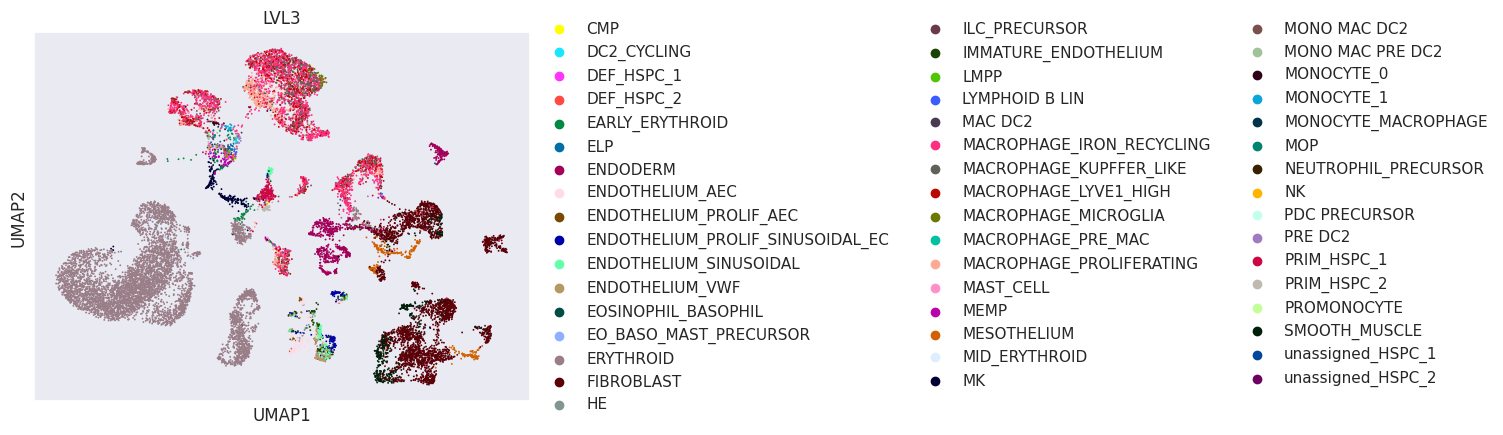

LVL3
CMP                                 0.000018
DC2_CYCLING                         0.000041
DEF_HSPC_1                          0.000130
DEF_HSPC_2                          0.000248
EARLY_ERYTHROID                     0.000413
ELP                                 0.000324
ENDODERM                            0.004460
ENDOTHELIUM_AEC                     0.001032
ENDOTHELIUM_PROLIF_AEC              0.000112
ENDOTHELIUM_PROLIF_SINUSOIDAL_EC    0.000891
ENDOTHELIUM_SINUSOIDAL              0.001127
ENDOTHELIUM_VWF                     0.000867
EOSINOPHIL_BASOPHIL                 0.000083
EO_BASO_MAST_PRECURSOR              0.000018
ERYTHROID                           0.035718
FIBROBLAST                          0.017375
HE                                  0.000177
ILC_PRECURSOR                       0.000100
IMMATURE_ENDOTHELIUM                0.000779
LMPP                                0.000106
LYMPHOID B LIN                      0.000059
MAC DC2                             0.000024
MACRO

In [23]:
# Generate random indices
s_rate = 0.1
n_samples = int(adata.shape[0]*s_rate)
random_indices = list(np.random.choice(adata.shape[0], size=n_samples, replace=False))
adata_samp_rand = adata[random_indices].to_memory()
sc.pp.normalize_per_cell(adata_samp_rand, counts_per_cell_after=1e4)
sc.pp.log1p(adata_samp_rand)
print(np.max(adata_samp_rand.X))
#pseudobulk_adata.obsm = adata_samp.obsm
sc.pp.highly_variable_genes(adata_samp_rand, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(adata_samp_rand,use_highly_variable=True)
sc.pp.neighbors(adata_samp_rand, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata_samp_rand)
sc.pl.umap(adata_samp_rand,color = 'LVL3')
adata_samp_rand.obs.groupby([grouping]).apply(len)/sum(adata.obs.groupby([grouping]).apply(len))

To quantify the difference between the explained variance of PCA components for the original data and the subsample, use the Root Mean Square Error (RMSE):

$$
\text{RMSE} = \sqrt{\frac{\sum_{i=1}^{n} (x_i - y_i)^2}{n}}
$$

Here \(x_i\) and \(y_i\) are the explained variances for the \(i\)-th principal component in the original and subsampled data, respectively, and \(n\) is the number of components

In [18]:
adata_tt = adata.copy()
sc.pp.normalize_per_cell(adata_tt, counts_per_cell_after=1e4)
sc.pp.log1p(adata_tt)
sc.pp.highly_variable_genes(adata_tt, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(adata_tt,use_highly_variable=True)

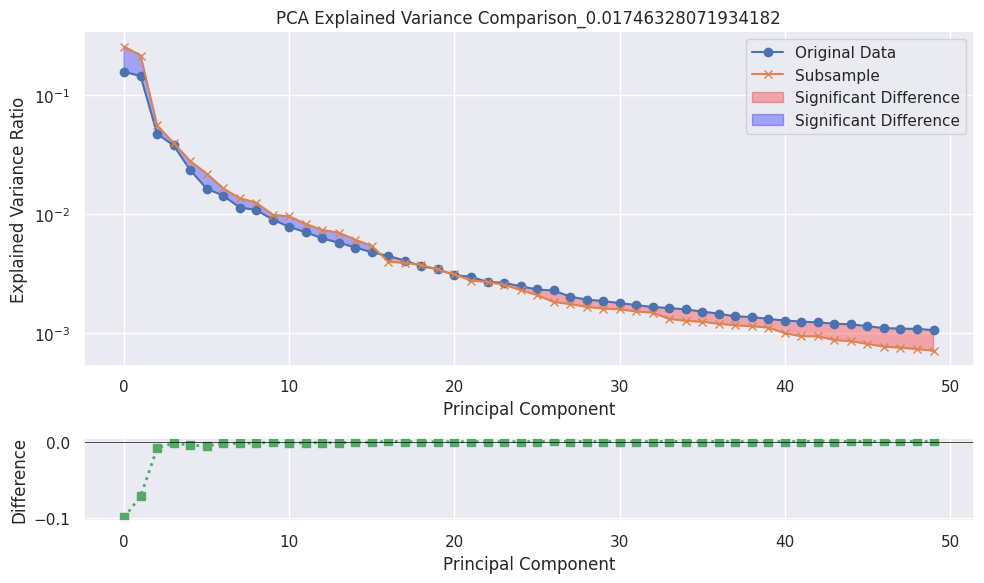

In [19]:
import matplotlib.pyplot as plt

# Step 1: Extract Explained Variance Ratios
explained_variance_adata = adata_tt.uns['pca']['variance_ratio']
explained_variance_adata_tmp = pseudobulk_adata_tt.uns['pca']['variance_ratio']

# Calculate the RMSE
n = len(explained_variance_adata)
rmse = np.sqrt(np.mean((explained_variance_adata - explained_variance_adata_tmp)**2))

fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [4, 1]})

# Main Plot
axes[0].plot(explained_variance_adata, label='Original Data', marker='o')
axes[0].plot(explained_variance_adata_tmp, label='Subsample', marker='x')
axes[0].fill_between(range(len(explained_variance_adata)), explained_variance_adata, explained_variance_adata_tmp, 
                     where=(explained_variance_adata - explained_variance_adata_tmp) > 0, color='red', alpha=0.3, label='Significant Difference')
axes[0].fill_between(range(len(explained_variance_adata)), explained_variance_adata, explained_variance_adata_tmp, 
                     where=(explained_variance_adata - explained_variance_adata_tmp) < 0, color='blue', alpha=0.3, label='Significant Difference')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Explained Variance Comparison_' + str(rmse))
axes[0].legend()
axes[0].set_yscale("log")

# Subplot for Differences
diff_variance = explained_variance_adata - explained_variance_adata_tmp
axes[1].plot(diff_variance, label='Difference', marker='s', linestyle=':', linewidth=2, markersize=6, color='g')
axes[1].axhline(0, color='black', linewidth=0.5)  # Zero line
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Difference')

plt.tight_layout()
plt.show()

# Train the EN model

In [ ]:
if train_model == True:
    from sklearn.preprocessing import StandardScaler
    #adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
    #if sample_data_knn != False:
    #    print('Empirical bayes sampling option selected')
    #    adata, indices = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, use_var, knn_key, sampling_rate= sample_data_knn, iterations=10, equal_allocation=False)
    #print('adata_loaded')
    import time
    t0 = time.time()
    display_cpu = scent.DisplayCPU()
    display_cpu.start()
    try:
        model_trained = scent.prep_training_data(
        adata_temp = adata,
        model_key = model_key + '_lr_model',
        **model_params
        )
        filename =model_name
        pkl.dump(model_trained, open(filename, 'wb'))
    finally: #
        current, peak = display_cpu.stop()
        t1 = time.time()
        time_s = t1-t0
        print('training complete!')
        time.sleep(3)
        print('projection time was ' + str(time_s) + ' seconds')
        print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
        print(f"starting memory usage is" +'' + str(display_cpu.starting))
        print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
        print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))
    model_lr= model_trained
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key)
else:
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key,QC_normalise)
    model = scent.load_models(models,model_key)
    model_lr =  model
    
# run with usage logger
import time
t0 = time.time()
display_cpu = scent.DisplayCPU()
display_cpu.start()
try: #code here ##
    pred_out,train_x,model_lr,adata_temp = scent.reference_projection(adata, model_lr, **model_params)
    if freq_redist != False:
        pred_out['orig_labels'] = adata.obs[freq_redist]
        pred_out = scent.freq_redist_68CI(pred_out,'orig_labels')
        adata.obs['consensus_clus_prediction'] = pred_out['consensus_clus_prediction']
    adata.obs['predicted'] = pred_out['predicted']
    adata_temp.obs = adata.obs
    
    # Estimate top model features for class descrimination
    feature_importance = scent.estimate_important_features(model_lr, 100)
    mat = feature_importance.euler_pow_mat
    top_loadings = feature_importance.to_n_features_long

finally: #
    current, peak = display_cpu.stop()
t1 = time.time()
time_s = t1-t0
print('projection complete!')
time.sleep(3)
print('projection time was ' + str(time_s) + ' seconds')
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(f"starting memory usage is" +'' + str(display_cpu.starting))
print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))

In [ ]:
if train_model == True:
    train_label = adata.obs[feat_use].values
else:
    train_label = adata.obs['predicted'].values
scent.report_f1(model_lr,train_x, train_label)

In [ ]:
if train_model == True:
    scent.regression_results(pred_out, 'orig_labels','predicted',list(model_lr.classes_))
else:
    scent.regression_results(pred_out, 'predicted','predicted',list(model_lr.classes_))

import scentinel# View by median probabilities per classification

In [ ]:
scent.plot_label_probability_heatmap(pred_out)

# View by cross-tabulation of two categorical attributes

In [ ]:
scent.plot_crosstab_heatmap(adata, 'cell.labels', 'predicted')
scent.plot_crosstab_heatmap(adata, 'consensus_clus_prediction', 'predicted')
scent.plot_crosstab_heatmap(adata,  'cell.labels','consensus_clus_prediction')

# View top predictive features per class

In [ ]:
top_loadings

In [ ]:
#Estimate dataset specific feature impact
from matplotlib import pyplot as plt
class_plot = list(model_lr.classes_)[0:3]
for classes in class_plot: #['pDC precursor_ys_HL','AEC_ys_HL']:
    scent.model_class_feature_plots(top_loadings, [str(classes)], 'e^coef','e^coef',20,'top_feat')
    plt.show()

# Save predicted output

In [ ]:
#pred_out.to_csv('./A1_V3_sk_sk_pred_outs.csv')

 # Assess feature impact on model predictions

In [ ]:
top_loadings

In [ ]:
# if using a low-dim model like PCA or ldVAE which has a weights layer
# top_loadings = compute_weighted_impact(varm_file = '/nfs/team205/ig7/projects/fetal_skin/3_160523_probabillistic_projection_organoid_adt_fetl/A2_V2_ldvae_models/v3_ldvae_obsm_weights.csv',top_loadings =  top_loadings, threshold=0.05)

for class_lin in top_loadings['class'].unique():
    scent.model_class_feature_plots(top_loadings, [class_lin], 'e^coef','e^coef',max_len= 20,title = class_lin)
    scent.analyze_and_plot_feat_gsea(top_loadings,class_lin, max_len=20, pre_ranked=True, database='GO_Biological_Process_2021', cutoff=0.25, min_s=5)

In [27]:
list(top_loadings['class'].unique())

['ABT(ENTRY)',
 'AS_DC',
 'B1',
 'CD4+T',
 'CD8+T',
 'CD8AA',
 'CHONDROCYTE',
 'CMP',
 'CYCLING_B',
 'CYCLING_DC',
 'CYCLING_EPITHELIUM',
 'CYCLING_FIBROBLAST_I',
 'CYCLING_FIBROBLAST_II',
 'CYCLING_ILC',
 'CYCLING_MEMP',
 'CYCLING_MPP',
 'CYCLING_NK',
 'CYCLING_PDC',
 'CYCLING_T',
 'CYCLING_YS_ERY',
 'DC1',
 'DC2',
 'DC_PROGENITOR',
 'DEVELOPING_NEPHRON_I',
 'DEVELOPING_NEPHRON_II',
 'DN(P)_T',
 'DN(Q)_T',
 'DN(early)_T',
 'DOUBLET',
 'DOUBLETS_FIBRO_ERY',
 'DOUBLET_ENDOTHELIUM_ERYTHROCYTE',
 'DOUBLET_ERY_B',
 'DOUBLET_IMMUNE_FIBROBLAST',
 'DOUBLET_LYMPHOID_MACROPHAGE',
 'DOUBLET_VSMC_ERYTHROCYTE',
 'DP(P)_T',
 'DP(Q)_T',
 'EARLY_ERY',
 'EARLY_MK',
 'ENDOTHELIUM_I',
 'ENDOTHELIUM_II',
 'ENDOTHELIUM_III',
 'ENDOTHELIUM_IV',
 'ENDOTHELIUM_V',
 'ENTEROENDOCRINE_I',
 'ENTEROENDOCRINE_II',
 'EOSINOPHIL_BASOPHIL',
 'EPITHELIUM_I',
 'EPITHELIUM_II',
 'FIBROBLAST_I',
 'FIBROBLAST_II',
 'FIBROBLAST_III',
 'FIBROBLAST_IV',
 'FIBROBLAST_IX',
 'FIBROBLAST_V',
 'FIBROBLAST_VI',
 'FIBROBLAST_VII',


In [28]:
top_loadings[top_loadings['class'].isin(['Tip cell (arterial)','HSC','SPP1+ proliferating neuron proneitors'])].groupby(['class']).head(10)

Empty DataFrame
Columns: [class, feature, e^coef, coef, e^coef_pval, is_significant_sf]
Index: []

# Let's now run this model in a tansductive format to generalise across across 

## Initialise a new projection run
- Here we generalise the transductive model across the entire dataset

In [ ]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
}

#setup global params:
# Variable assignment
train_model = False
adata_key = 'YS_local'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'new_example_model'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'LVL3'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False # should data be normalised?
sample_data_knn = 0.1 # Apply empirical bayes sampling weighted by knn?

# setup model parameters:
model_params = {
'feat_use': 'LVL3',
'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
}

In [ ]:
if train_model == True:
    from sklearn.preprocessing import StandardScaler
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
    #if sample_data_knn != False:
    #    print('Empirical bayes sampling option selected')
    #    adata, indices = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, use_var, knn_key, sampling_rate= sample_data_knn, iterations=10, equal_allocation=False)
    #print('adata_loaded')
    import time
    t0 = time.time()
    display_cpu = scent.DisplayCPU()
    display_cpu.start()
    try:
        model_trained = scent.prep_training_data(
        adata_temp = adata,
        model_key = model_key + '_lr_model',
        **model_params
        )
        filename =model_name
        pkl.dump(model_trained, open(filename, 'wb'))
    finally: #
        current, peak = display_cpu.stop()
        t1 = time.time()
        time_s = t1-t0
        print('training complete!')
        time.sleep(3)
        print('projection time was ' + str(time_s) + ' seconds')
        print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
        print(f"starting memory usage is" +'' + str(display_cpu.starting))
        print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
        print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))
    model_lr= model_trained
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key)
else:
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key,QC_normalise)
    model = scent.load_models(models,model_key)
    model_lr =  model
    
# run with usage logger
import time
t0 = time.time()
display_cpu = scent.DisplayCPU()
display_cpu.start()
try: #code here ##
    pred_out,train_x,model_lr,adata_temp = scent.reference_projection(adata, model_lr, **model_params)
    if freq_redist != False:
        pred_out['orig_labels'] = adata.obs[freq_redist]
        pred_out = scent.freq_redist_68CI(pred_out,'orig_labels')
        adata.obs['consensus_clus_prediction'] = pred_out['consensus_clus_prediction']
    adata.obs['predicted'] = pred_out['predicted']
    adata_temp.obs = adata.obs
    
    # Estimate top model features for class descrimination
    feature_importance = scent.estimate_important_features(model_lr, 100)
    mat = feature_importance.euler_pow_mat
    top_loadings = feature_importance.to_n_features_long

finally: #
    current, peak = display_cpu.stop()
t1 = time.time()
time_s = t1-t0
print('projection complete!')
time.sleep(3)
print('projection time was ' + str(time_s) + ' seconds')
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(f"starting memory usage is" +'' + str(display_cpu.starting))
print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))

# Now assess the generalised predictions

In [ ]:
if train_model == True:
    train_label = adata.obs[feat_use].values
else:
    train_label = adata.obs['predicted'].values
scent.report_f1(model_lr,train_x, train_label)

In [ ]:
if train_model == True:
    scent.regression_results(pred_out, 'orig_labels','predicted',list(model_lr.classes_))
else:
    scent.regression_results(pred_out, 'predicted','predicted',list(model_lr.classes_))

import scentinel# View by median probabilities per classification

In [ ]:
scent.plot_label_probability_heatmap(pred_out)

# View by cross-tabulation of two categorical attributes

In [ ]:
scent.plot_crosstab_heatmap(adata, 'cell.labels', 'predicted')
scent.plot_crosstab_heatmap(adata, 'consensus_clus_prediction', 'predicted')
scent.plot_crosstab_heatmap(adata,  'cell.labels','consensus_clus_prediction')

# Let's calculate an impact and specificty score for each cell

- We create a variable model impact factor by multiplying gene x model coeficient for class
- This is the variable contribution of each feature for a class prediction given a model and data

$X = $$\begin{bmatrix}(e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ (e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ (e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ ..... \end{bmatrix}$

- We create a summed feature impact score for each cell by summing per feature ipact scores which identifies the overarching impact of a model's contribution.. == total model impact score

$Impact_{cellx} = $$\begin{bmatrix}(e^{coeff}_{n} * g1) + \ (e^{coeff}_{n} * g2) \ +(e^{coeff}_{n} * g3) \ + ..... \end{bmatrix}$

- We measure the model feature effect on class decisoion betwene organs and withi organs
- We can now use these feature availability/impact metrics to compare the availability and differential impact of features between data for transductive and/or inductive runs

In [30]:
df_impact = scent.calculate_feature_distribution(adata, top_loadings, var='predicted')
df_impact

TypeError: calculate_feature_distribution() missing 1 required positional argument: 'top_loadings'

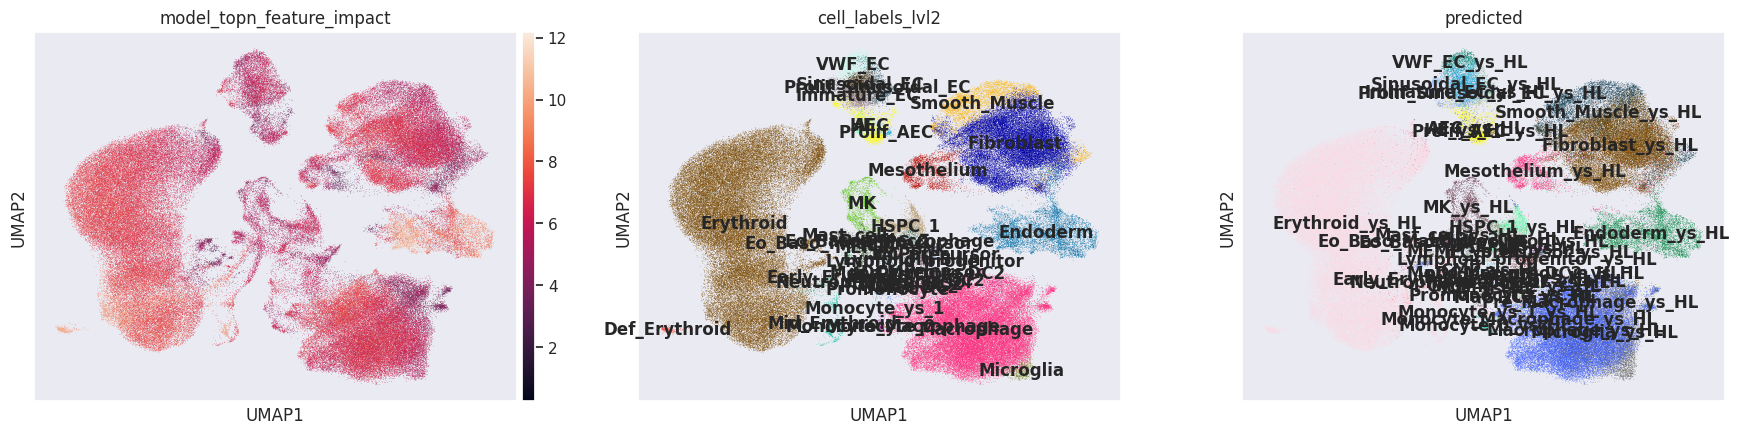

In [18]:
sc.pl.umap(adata_model,color =[ 'model_topn_feature_impact','cell_labels_lvl2','predicted'],legend_loc = 'on data')

# Label stability scoring for individual label performance

In [31]:
# pred_col shape should match the pred_out original labels, so some self-projection works best here
pred_col = list(pred_out.columns[pred_out.columns.isin(set(pred_out['orig_labels']))])
loss, log_losses, weights = scent.compute_label_log_losses(pred_out, 'orig_labels', pred_col)

/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [36]:
print('This is our global entropy {}'.format(loss))
print('This is our per-label entropy {}'.format(log_losses))
print('This is our per-label weight {}'.format(weights))

This is our global entropy 24.504262359941666
This is our per-label entropy {'B cell': 0.34397726937068196, 'DC1': 0.10711433040644056, 'DC2': 0.43402919503320114, 'DC precursor': 0.025543967131300128, 'Early Erythroid': 3.820729910479723, 'Early lymphoid_T lymphocyte': 0.24451396256470181, 'Endothelial cell': 1.0673177922641732, 'Fibroblast': 0.5460918094828342, 'HSC_MPP': 0.1534324468272948, 'Hepatocyte': 0.7902869793975166, 'ILC precursor': 0.5502361139330835, 'Kupffer Cell': 7.919128219126143, 'Late Erythroid': 1.0137606270609532, 'MEMP': 0.06365031058941667, 'Mast cell': 0.41698078622507134, 'Megakaryocyte': 1.269751125026345, 'Mid Erythroid': 8.607401550517524, 'Mono-Mac': 2.1008435636263147, 'Monocyte': 0.8243977929495675, 'Monocyte precursor': 0.1115774275067089, 'NK': 0.5238048845241574, 'Neutrophil-myeloid progenitor': 0.2097655637126125, 'Pre pro B cell': 0.07459748010448546, 'VCAM1+ EI macrophage': 0.05132561665308621, 'pDC precursor': 0.08065454045484963, 'pre-B cell': 0.4

# Future modules

# Label confidence scoring, weighted probabilities and label propagation

## Bayesian KNN label stability
For modelling label uncertainty given neighborhood membership and distances

#### Step 1: Generate Binary Neighborhood Membership Matrix
The first step is to generate a binary neighborhood membership matrix from the connectivity matrix. This is done with the function get_binary_neigh_matrix(connectivities), which takes a connectivity matrix as input and outputs a binary matrix indicating whether a cell is a neighbor of another cell.

The connectivity matrix represents the neighborhood relationships between cells, typically obtained from KNN analysis. In this matrix, each row and column represent a cell, and an entry indicates the 'connectivity' between the corresponding cells.

The function transforms the connectivity matrix into a binary matrix by setting all non-zero values to 1, indicating a neighborhood relationship, and all zero values remain as 0, indicating no neighborhood relationship.

#### Step 2: Calculate Label Counts
Next, the function get_label_counts(neigh_matrix, labels) is used to count the number of occurrences of each label in the neighborhood of each cell. The input to this function is the binary neighborhood membership matrix and a list of labels for each cell.

The function returns a matrix in which each row corresponds to a cell, and each column corresponds to a label. Each entry is the count of cells of a particular label in the neighborhood of a given cell.

#### Step 3: Compute Distance-Entropy Product
In the third step, the function compute_dist_entropy_product(neigh_membership, labels, dist_matrix) computes the product of the average neighborhood distance and the entropy of the label distribution in the neighborhood for each cell and each label.

The entropy of a label distribution in a neighborhood is a measure of the diversity or 'mix' of labels in that neighborhood, with higher entropy indicating a more diverse mix of labels. The average neighborhood distance for a cell is the average distance from that cell to all other cells in its neighborhood.

By multiplying the entropy with the average distance, this function captures two important aspects of the neighborhood:

Entropy: The diversity of labels in a neighborhood. High entropy means the neighborhood is a 'melting pot' of many different labels, while low entropy indicates a neighborhood dominated by a single label.
Distance: The spatial proximity of cells in a neighborhood. A high average distance means the cells in a neighborhood are widely dispersed, while a low average distance indicates a compact, closely-knit neighborhood.
Thus, the distance-entropy product for a cell provides a measure of the 'stability' of the cell's label, with lower values indicating a stable, consistent label and higher values indicating an unstable, inconsistent label.

#### Step 4: Bayesian Sampling and Weight Calculation
The final step is the compute_weights function, which uses Bayesian inference to compute a posterior distribution of the distance-entropy product for each label and calculates the weights.

In Bayesian inference, we start with a prior distribution that represents our initial belief about the parameter we're interested in, and we update this belief using observed data to get a posterior distribution.

In this case, the prior distribution is a normal distribution with mean and standard deviation equal to the mean and standard deviation of the distance-entropy product for the original labels. The observed data is the distance-entropy product for the predicted labels. A normal distribution is a reasonable choice for the prior because the distance-entropy product is a continuous variable that can theoretically take on any real value, and the normal distribution is the most common distribution for such variables.

After sampling from the posterior distribution, the weight for each label is calculated as one minus the ratio of the standard deviation of the posterior distribution to the maximum standard deviation across all labels. This means that labels with a larger standard deviation (indicating greater uncertainty about their stability) will have smaller weights, and labels with a smaller standard deviation (indicating less uncertainty) will have larger weights.

The weights are returned as a dictionary where each key-value pair corresponds to a label and its weight.

#### Step 5: Apply Weights to Probabilities
Finally, the weights are applied to the probability dataframe with the function apply_weights(prob_df, weights). The input to this function is a dataframe where each row corresponds to a cell and each column corresponds to a label, with each entry being the probability of the cell being of the label, and a dictionary of weights.

This function multiplies each column of the probability dataframe by the corresponding weight, effectively 'boosting' the probabilities of labels with larger weights and 'penalizing' the probabilities of labels with smaller weights. After applying the weights, the function normalizes the probabilities so that they sum to 1 for each cell, returning a dataframe of the same shape as the input but with the probabilities weighted and normalized.

Overall, this method provides a principled way to quantify label uncertainty and adjust the probabilities output by a logistic regression model accordingly. It combines the strengths of KNN, which can capture local structure and relationships in the data, and Bayesian inference, which provides a robust framework for dealing with uncertainty and incorporating prior knowledge. By weighting the probabilities according to the stability of the labels, this method can potentially improve the accuracy and interpretability of the logistic regression model's predictions.

In [43]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors = 30)

/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10

In [ ]:
weights = scent.compute_weights(adata,use_rep = 'neighbors', original_labels_col ='consensus_clus_prediction', predicted_labels_col = 'consensus_clus_prediction')
adata.obsm['pred_out'] = pred_out
adata.obsm['pred_out_weighted'] = apply_weights(adata.obsm['pred_out'],weights)

In [7]:
adata_samp = sample_anndata(adata)

In [ ]:
# use_rep = 'neighbors'
# original_labels_col ='cell.labels'
# predicted_labels_col = 'cell.labels'
    

# # Extract the necessary data from the anndata object
# obs_met = adata.obs
# neigh_membership = get_binary_neigh_matrix(adata.obsp[adata.uns[use_rep]['connectivities_key']])
# original_labels = obs_met[original_labels_col]
# predicted_labels = obs_met[predicted_labels_col]
# dist_matrix = adata.obsp[adata.uns[use_rep]['distances_key']]

# # Compute the 'distance-entropy' product for each cell and each label
# dist_entropy_product = compute_dist_entropy_product(neigh_membership, predicted_labels, dist_matrix)

# # Compute the 'distance-entropy' product for the original labels
# dist_entropy_product_orig = compute_dist_entropy_product(neigh_membership, original_labels, dist_matrix)

# weights = {}
# rhat_values = {}
# means = []  # Collect all posterior means
# sds = []  # Collect all posterior standard deviations
# for label in np.unique(predicted_labels):
#     print("Sampling {} posterior distribution".format(label))
#     # Perform Bayesian inference to compute the posterior distribution of the
#     # 'distance-entropy' product for this label
#     orig_pos = obs_met[original_labels_col].isin([label])
#     pred_pos = obs_met[predicted_labels_col].isin([label])
#     with pm.Model() as model:
#         #priors
#         mu = pm.Normal('mu', mu=dist_entropy_product_orig[orig_pos.values].mean(), sd=dist_entropy_product_orig[orig_pos.values].std())
#         sd = pm.HalfNormal('sd', sd=dist_entropy_product_orig[orig_pos.values].std())
#         #observations
#         obs = pm.Normal('obs', mu=mu, sd=sd, observed=dist_entropy_product_orig[pred_pos.values])

# #         if len(orig_pos) > 10000:
# #             samp_rate = 0.1
# #             smp = int(len(orig_pos)*samp_rate)
# #             tne = int((len(orig_pos)*samp_rate)/2)
# #             trace = pm.sample(smp, tune=tne)
# #         else:
#         trace = pm.sample(1000, tune=500)
#     # Compute R-hat for this label
#     rhat = pm.rhat(trace)
#     rhat_values[label] = {var: rhat[var].data for var in rhat.variables}
#     # Compute the mean and the standard deviation of the posterior distribution for this label
#     mean_posterior = pm.summary(trace)['mean']['mu']
#     sd_posterior = pm.summary(trace)['sd']['sd']
#     sds.append(sd_posterior)
#     means.append(mean_posterior)

# # Mean posterior probabilitty models the stability of a label given entropy_distance measures within it's neighborhood
# max_mean = max(means)
# # SD here models the uncertainty of label entropy_distance measures
# max_sd = max(sds)  # Compute the maximum standard deviation

# # Compute the weights as the sum of the normalized mean and the normalized standard deviation. This makes each weight relative to each other
# # shift all weights up by epiislon constant
# epsilon = 0.01
# for label, mean, sd in zip(np.unique(predicted_labels), means, sds):
#     weights[label] = (1 - mean / max_mean) * (1 - sd / max_sd) + epsilon

# Optionally now use the updated probabilities for label propagation 

In [403]:
# Here define new labels with the updated probabilities
# Run Freq-redist or 68CI redist amongst neighborhoods or new clusters

In [7]:
adata_samp = sample_anndata(adata)